In [1]:
#from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
from collections import deque
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from operator import itemgetter 

In [2]:
mypath = 'eric_jh_data/'
countries = sorted(['Australia', 'Japan', 'China'])
fx_dict = {'Australia':('eric_jh_data/Forex/AUD_USD_new.csv',0),
           'Japan':('eric_jh_data/Forex/USD_JPY_new.csv',1),
           'China':('eric_jh_data/Forex/USD_HKD_new.csv',1)}

list_pairs = []
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    for adr in sorted(adr_names):
        list_pairs.append((country, adr))

In [3]:
def data_processing(country, adr, fx_dict, forex_bps = 10, adjust_forex_expense = True):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    ratio_path = f'eric_jh_data/{country}/{adr}/ratio.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open', 'volume' : 'adr_volume'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open', 'volume' : 'stock_volume'})
    fx_df = pd.read_csv(fx_path, index_col = 0)
    ratio_df = pd.read_csv(ratio_path, index_col = 0)

    # Invert fx data so that all prices are reflected in USD
    if fx_type == 0:
        inverted_fx_df = 1/fx_df.iloc[:,[2,1,3,5,4,6,8,7,9,11,10,12]].copy()
        inverted_fx_df.columns = fx_df.columns[1:-1]
        fx_df.iloc[:,1:-1] = inverted_fx_df
    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close', 'adr_volume']], stock_df.loc[:,['date', 'stock_open','stock_close', 'stock_volume']])
    merged_df = pd.merge(merged_df, fx_df)
    ratio_geq_1, ratio = ratio_df["ratio_geq_1"].item(), ratio_df["ratio"].item()

#     ratio is (stock price in USD)/(ADR price)
#     If ratio >= 1, we shall buy 1 stock, and sell multiple adrs
#     If ratio < 1, we shall sell 1 adr, and buy multiple stocks
    if ratio_geq_1:
        merged_df["stock_num_per_unit"] = 1
        merged_df["adr_num_per_unit"] = ratio
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]*ratio
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]*ratio
    else:
        merged_df["stock_num_per_unit"] = ratio
        merged_df["adr_num_per_unit"] = 1
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]*ratio
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]*ratio
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]    
    
    if adjust_forex_expense:
        # Added expense for trading small amounts in forex market
        forex_bid_multiplier = 1 - 0.0001*forex_bps
        forex_ask_multiplier = 1 + 0.0001*forex_bps
        merged_df.loc[:,merged_df.columns.str.contains("bid")] *= forex_bid_multiplier
        merged_df.loc[:,merged_df.columns.str.contains("ask")] *= forex_ask_multiplier
        
    return merged_df

In [4]:
def calc_max_drawdown(portfolio_values, method = "percentage"):
    peak, trough = portfolio_values[0], portfolio_values[0]
    max_drawdown = 0
    for i in range(1, len(portfolio_values)):
        if portfolio_values[i] < trough:
            trough = portfolio_values[i]
            if method == "percentage":
                max_drawdown = max(max_drawdown, (peak - trough)/peak)
            else:
                max_drawdown = max(max_drawdown, peak - trough)
        elif portfolio_values[i] > peak:
            peak, trough = portfolio_values[i], portfolio_values[i]
    return max_drawdown

In [5]:
def get_risk_statistics(stock_values, adr_values, var_ci):
    port_stock = stock_values - adr_values
    port = pd.DataFrame(data = port_stock)
    port_diff = port - port.shift(1)
    pnl = pd.DataFrame(port_diff).dropna()
    sigma = pnl.std()[0]
    pnl['pct_rank'] = pnl.rank(pct=True)
    pnl.columns =['daily_pl', 'pct_rank']
    var = abs(pnl[pnl.pct_rank< 1-var_ci].daily_pl.max())
    max_drawdown_abs = calc_max_drawdown(port_stock, "absolute")
    return sigma, var, max_drawdown_abs

In [6]:
def plot_returns(dates, portfolio_values, num_xticks = 5):
    plt.plot(portfolio_values)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)// num_xticks)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), rotation = 45)
    plt.show();

In [7]:
def calc_sharpe(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    returns = (portfolio_values[1:] - portfolio_values[:-1])/portfolio_values[:-1]
    return np.round(np.sqrt(252)*np.mean(returns)/np.std(returns), 2)

In [8]:
list_pairs_copy = list_pairs.copy()
list_pairs_aus = list_pairs[:9]
list_pairs_chi = list_pairs[9:18]
list_pairs_jap = list_pairs[18:]

In [10]:
list_pairs = [("Australia", "PLL_PLL"),
               ("Australia", "MESO_MSB"),
               ("Australia", "GENE_GTG"),
               ("Australia", "WBK_WBC"),
               ("Australia", "KZIA_KZA"),
               ("Australia", "IMMP_IMM"),
               ("Australia", "IMRN_IMC"),
               ("Australia", "ATHE_ATH"),
               ("Australia", "JHX_JHX"),
               ("Japan", "SONY_6758"), 
               ("Japan", "TAK_4502"),
               ("Japan", "TM_7203"),
               ("Japan", "SMFG_8316"),
               ("China", "BGNE_6160"), 
               ("China", "SNP_386")]

In [45]:
fname = 'results1_sfx_all.txt'
with open(fname, 'r') as f:
    is_res = f.readlines()
hp = {}
for i in range(len(list_pairs_copy)):
    hp[list_pairs_copy[i]] = [float(x) for x in is_res[i*5 + 4].split("(")[1].split(")")[0].split(", ")]

# Final Strategy

In [38]:
df_dict = {}
for (country, adr) in list_pairs_copy:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
date_set = set()
for (country, adr) in list_pairs_copy:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)

In [39]:
def final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, cash = 250000, 
                   start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, borrowing_bps = 50, 
                   risk_lookback = 100, cooldown = 100, cooldown_limit = 100, var_ci = 0.95, var_limit = 0.1, 
                   max_drawdown_limit = 0.2, sigma_limit = 0.05, stop_loss_limit = 0.15, maximum_holding_period = 30, 
                   volume_lookback = 5, adjust_for_risk = False):

    trading_limit = {"Australia" : trading_limits[0], "China" : trading_limits[1], "Japan" : trading_limits[2]}
    num_traded = {"Australia" : [], "China" : [], "Japan" : []}

    hp_dict = {}
    for (country, adr) in list_pairs:
        hp_dict[(country, adr)] = {}
        hp_dict[(country, adr)]["lookback"] = int(hp[(country, adr)][0])
        hp_dict[(country, adr)]["entry"] = hp[(country, adr)][1]
        hp_dict[(country, adr)]["exit"] = hp[(country, adr)][2]
        hp_dict[(country, adr)]["stop_loss"] = hp[(country, adr)][3]
        if country == "Australia":
            hp_dict[(country, adr)]["allocation"] = allocation[0]*(1/trading_limit["Australia"]) #((1/9)*(1/3))/(9/17)
            hp_dict[(country, adr)]["original_allocation"] = allocation[0]*(1/trading_limit["Australia"]) #((1/9)*(1/3))/(9/17)
        elif country == "China":
            hp_dict[(country, adr)]["allocation"] = allocation[1]*(1/trading_limit["China"]) #1((1/9)*(2/3))/(8/17)
            hp_dict[(country, adr)]["original_allocation"] = allocation[1]*(1/trading_limit["China"]) #((1/9)*(2/3))/(8/17)
        elif country == "Japan":
            hp_dict[(country, adr)]["allocation"] = allocation[2]*(1/trading_limit["Japan"]) #1((1/9)*(2/3))/(8/17)
            hp_dict[(country, adr)]["original_allocation"] = allocation[2]*(1/trading_limit["Japan"]) #((1/9)*(2/3))/(8/17)

    diff_record_dict = {}
    for (country, adr) in list_pairs:
        diff_record_dict[(country, adr)] = deque(maxlen = 2*hp_dict[(country, adr)]["lookback"])

    conditions = {}
    for (country, adr) in list_pairs:
        conditions[(country, adr)] = {}
        conditions[(country, adr)]["enter_cond1"] = False
        conditions[(country, adr)]["exit_cond1"] = False
        conditions[(country, adr)]["enter_cond2"] = False
        conditions[(country, adr)]["exit_cond2"] = False

    iter_dict = {}
    for (country, adr) in list_pairs:
        iter_dict[(country, adr)] = {}
        iter_dict[(country, adr)]["index"] = 0

    positions = {}
    for (country, adr) in list_pairs:
        positions[(country, adr)] = {}
        positions[(country, adr)]["stock_pos"] = 0
        positions[(country, adr)]["adr_pos"] = 0
        positions[(country, adr)]["prev_adr_pos"] = 0
        positions[(country, adr)]["holding_period"] = None
        positions[(country, adr)]["trade_type"] = None

    forex_dict = {}
    for (country, adr) in list_pairs:
        forex_dict[(country, adr)] = {}
        forex_dict[(country, adr)]["forex_cash"] = 0
        forex_dict[(country, adr)]["prev_forex_value"] = 0

    trade_records = []
    portfolio_values = []
    portfolio_values_for_risk = []
    num_pairs_traded_list_aus = []
    num_pairs_traded_list_hk = []
    num_pairs_traded_list_jap = []
    dates = []
    
    breach1 = False
    breach2 = False
    
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash = cash
    
    for i in range(1, len(datelist)):
        current_date = datelist[i]
        prev_date = datelist[i-1]
        if current_date >= start_date and prev_date <= end_date:
            cooldown += 1
            dates.append(prev_date)
            prev_value = prev_cash
            for country in countries:
                num_traded[country].append(0)
            for (country, adr) in list_pairs:
                index = iter_dict[(country, adr)]["index"]
                merged_df = df_dict[(country, adr)]
                row = merged_df.loc[index]
                if positions[(country, adr)]["stock_pos"] > 0:
                    num_traded[country][-1] += 1
                if index > 0:
                    # Add adr values
                    prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                    # Add stock values
                    forex_dict[(country, adr)]["prev_forex_value"] = forex_dict[(country, adr)]["forex_cash"] 
                    forex_dict[(country, adr)]["prev_forex_value"] += positions[(country, adr)]["stock_pos"]*row['stock_open']
                    if forex_dict[(country, adr)]["prev_forex_value"] > 0:
                        forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_ask_non_us_at']
                    elif forex_dict[(country, adr)]["prev_forex_value"] < 0:
                        forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_bid_non_us_at']
                    prev_value += forex_dict[(country, adr)]["prev_forex_value"]
            portfolio_values.append(prev_value)
            portfolio_values_for_risk.append(prev_value)

            for (country, adr) in list_pairs:
                index = iter_dict[(country, adr)]["index"]
                merged_df = df_dict[(country, adr)]
                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                if positions[(country, adr)]["stock_pos"] > 0:
                    positions[(country, adr)]["holding_period"] += 1
                    cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
                    multiplier = (1 + 0.01*(2 + merged_df.loc[index]["ir"])*(1/252))
                    forex_dict[(country, adr)]["forex_cash"] *= multiplier
            prev_cash = cash

            # risk tests
            if cooldown >= cooldown_limit and adjust_for_risk:
                max_drawdown = calc_max_drawdown(portfolio_values_for_risk, method = "absolute")
                starting_cash = portfolio_values_for_risk[0]
                cum_pl = prev_value - starting_cash
                # fraction to liquidate
                liquidate_frac = 0
                if max_drawdown > max_drawdown_limit*starting_cash or cum_pl < -stop_loss_limit*starting_cash:
                    liquidate_frac = 1
                    cooldown = 0
                    portfolio_values_for_risk = []
                    breach1 = False
                    breach2 = False
                    # Return to original allocation after cooldown.
                    # In real-life, someone would step in and redecide if this is appropriate
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] = hp_dict[(country, adr)]["original_allocation"]
                elif (max_drawdown > 0.75*max_drawdown_limit*starting_cash or cum_pl < -0.75*stop_loss_limit*starting_cash) and not breach2:
                    liquidate_frac = 0.5
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] *= (1/3)
                    breach2 = True
                elif (max_drawdown > 0.5*max_drawdown_limit*starting_cash or cum_pl < -0.5*stop_loss_limit*starting_cash) and not breach1:
                    liquidate_frac = 1/3
                    for (country, adr) in list_pairs:
                        hp_dict[(country, adr)]["allocation"] *= (1/2)
                    breach1 = True

                # Calculate VaR and sigma test everyday right at Asian open
                stock_values = np.zeros(risk_lookback)
                adr_values = np.zeros(risk_lookback)
                for (country, adr) in list_pairs:
                    index = iter_dict[(country, adr)]["index"]
                    merged_df = df_dict[(country, adr)]
                    if index > 0:
                        temp_risk_lookback = min(risk_lookback, index)
                        current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                        ind_stock_values = (np.array(current["stock_open"])/np.array(current["avg_non_us_at"]))*positions[(country, adr)]["stock_pos"] 
                        ind_adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*positions[(country, adr)]["adr_pos"])
                        stock_values[-len(ind_stock_values):] += ind_stock_values
                        adr_values[-len(ind_adr_values):] += ind_adr_values
                sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                if sigma > prev_value*sigma_limit:
                    new_liquidate_frac = (sigma - prev_value*sigma_limit)/(prev_value*sigma_limit)
                    liquidate_frac = max(liquidate_frac, new_liquidate_frac)

                if var > prev_value*var_limit:
                    new_liquidate_frac = (var - prev_value*var_limit)/(prev_value*var_limit)
                    liquidate_frac = max(liquidate_frac, new_liquidate_frac)

                # Liquidate if necessary
                if liquidate_frac > 0:
                    for (country, adr) in list_pairs:
                        index = iter_dict[(country, adr)]["index"]
                        merged_df = df_dict[(country, adr)]
                        if index > 0 and index+1 < len(merged_df):
                            row = merged_df.loc[index]
                            stock_pos = positions[(country, adr)]["stock_pos"]
                            adr_pos = positions[(country, adr)]["adr_pos"]
                            if stock_pos > 0:
                                units_traded = stock_pos/row["stock_num_per_unit"]
                                units_liquidated = math.ceil(units_traded*liquidate_frac)
                                stock_quantity_sold = int(units_liquidated*row["stock_num_per_unit"])
                                adr_quantity_bought = int(units_liquidated*row["adr_num_per_unit"])
                                adr_px = row['adr_open']*long_multiplier
                                cash -= adr_quantity_bought*adr_px
                                prev_cash -= adr_quantity_bought*adr_px

                                stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                leftover_forex_cash = forex_dict[(country, adr)]["forex_cash"]*liquidate_frac
                                leftover_forex_cash += stock_px_fx*stock_quantity_sold
                                forex_dict[(country, adr)]["forex_cash"] *= (1-liquidate_frac)
                                if leftover_forex_cash > 0:
                                    leftover_forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                else:
                                    leftover_forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash += leftover_forex_cash
                                prev_cash += leftover_forex_cash

                                trade_records.append("Liquidating positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                positions[(country, adr)]["adr_pos"] += adr_quantity_bought
                                positions[(country, adr)]["stock_pos"] -= stock_quantity_sold
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                if liquidate_frac == 1:
                                    positions[(country, adr)]["holding_period"] = None
                                    num_traded[country][-1] += 1

        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            lookback = 2*hp_dict[(country, adr)]["lookback"]

            if index+1 < len(merged_df):
                row = merged_df.loc[index]
                if row["date"] == current_date:
                    iter_dict[(country, adr)]["index"] += 1
                    if index > 0: 
                        diff_record = diff_record_dict[(country, adr)]
                        entry = hp_dict[(country, adr)]["entry"]
                        exit = hp_dict[(country, adr)]["exit"]
                        stop_loss = hp_dict[(country, adr)]["stop_loss"]
                        stock_pos = positions[(country, adr)]["stock_pos"]
                        adr_pos = positions[(country, adr)]["adr_pos"]
                        holding_period = positions[(country, adr)]["holding_period"]
                        trade_type = positions[(country, adr)]["trade_type"]
                        stock_name = adr.split("_")[1]
                        adr_name = adr.split("_")[0]
                        enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                        exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                        enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                        exit_cond2 = conditions[(country, adr)]["exit_cond2"]

                        diff_record.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
                        if len(diff_record) == lookback and row["date"] >= start_date and row["date"] <= end_date and cooldown >= cooldown_limit:
                            mean = np.array(diff_record).mean()
                            std = np.array(diff_record).std()

                            if not (enter_cond2 or exit_cond2):
                                enter_cond1 = (diff_record[-1] > mean + entry*std
                                               and diff_record[-1] <= mean + stop_loss*std
                                               and stock_pos == 0 and adr_pos == 0 
                                               and num_traded[country][-1] < trading_limit[country])
                                exit_cond1 = ((diff_record[-1] < mean + exit*std
                                              or diff_record[-1] > mean + stop_loss*std
                                              or (holding_period == maximum_holding_period and trade_type == 1))
                                              and stock_pos > 0 and adr_pos < 0)

                                if enter_cond1:
                                    portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                    units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                                    (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_us_before']), 
                                                    adr_volume, 
                                                    stock_volume))
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])

                                    # Take portfolio value for each previous day when the US market opens
                                    temp_risk_lookback = min(risk_lookback, index)
                                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                    stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                    if (var > portfolio_value_before_entering*var_limit or 
                                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                        sigma > portfolio_value_before_entering*sigma_limit):
                                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                                        units = int(frac*units)
                                        if units == 0:
                                            enter_cond1 = False
                                        adr_quantity = int(units*row["adr_num_per_unit"])
                                        stock_quantity = int(units*row["stock_num_per_unit"])   
                                    if units != 0:

                                        adr_pos -= adr_quantity
                                        positions[(country, adr)]["adr_pos"] -= adr_quantity
                                        adr_px = row['adr_open']*short_multiplier
                                        cash += adr_quantity*adr_px
                                        prev_cash += adr_quantity*adr_px

                                        stock_pos += stock_quantity
                                        positions[(country, adr)]["stock_pos"] += stock_quantity
                                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                        forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity

                                        positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                        positions[(country, adr)]["holding_period"] = 0
                                        positions[(country, adr)]["trade_type"] = 1
                                        num_traded[country][-1] += 1

                                        trade_records.append("Opening positions:\n")
                                        # Times in EST
                                        trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                elif exit_cond1:
                                    adr_px = row['adr_open']*long_multiplier
                                    cash -= abs(adr_pos)*adr_px
                                    prev_cash -= abs(adr_pos)*adr_px

                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                    forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                    if forex_dict[(country, adr)]["forex_cash"] > 0:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                    else:
                                        forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                    cash += forex_dict[(country, adr)]["forex_cash"]
                                    prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                    forex_dict[(country, adr)]["forex_cash"] = 0

                                    trade_records.append("Closing positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                    trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                    positions[(country, adr)]["stock_pos"] = 0
                                    positions[(country, adr)]["adr_pos"] = 0
                                    positions[(country, adr)]["holding_period"] = None
                                    positions[(country, adr)]["trade_type"] = None
                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                    num_traded[country][-1] -= 1

                                conditions[(country, adr)]["enter_cond1"] = enter_cond1
                                conditions[(country, adr)]["exit_cond1"] = exit_cond1

                        diff_record = diff_record_dict[(country, adr)]["cond2"] if variant == "3a" else diff_record_dict[(country, adr)]
                        if variant != "2":
                            diff_record.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])
                            if len(diff_record) == lookback and row["date"] >= start_date and merged_df.loc[index+1,"date"] <= end_date:
                                mean = np.array(diff_record).mean()
                                std = np.array(diff_record).std()

                                if not (enter_cond1 or exit_cond1):

                                    # Check and possibly trade condition 2
                                    enter_cond2 = (diff_record[-1] > mean + entry*std
                                                   and diff_record[-1] <= mean + stop_loss*std
                                                   and stock_pos == 0 and adr_pos == 0 
                                                   and num_traded[country][-1] < trading_limit[country])
                                    exit_cond2 = ((diff_record[-1] < mean + exit*std
                                                  or diff_record[-1] > mean + stop_loss*std
                                                  or (holding_period == maximum_holding_period and trade_type == 2))
                                                  and stock_pos > 0 and adr_pos < 0)

                                    if enter_cond2:

                                        portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                        adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                        stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                        units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                                        (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                                        adr_volume, 
                                                        stock_volume))
                                        adr_quantity = int(units*row["adr_num_per_unit"])
                                        stock_quantity = int(units*row["stock_num_per_unit"])

                                        # Take portfolio value for each previous day when the Asian market opens
                                        temp_risk_lookback = min(risk_lookback, index)
                                        current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                        next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                                        stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                                        adr_values = np.array(current["adr_close"]*adr_quantity)
                                        sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                        if (var > portfolio_value_before_entering*var_limit or 
                                            max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                            sigma > portfolio_value_before_entering*sigma_limit):
                                            frac = min((portfolio_value_before_entering*var_limit)/var, 
                                                       (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                                      (portfolio_value_before_entering*sigma_limit)/sigma)
                                            units = int(frac*units)
                                            if units == 0:
                                                enter_cond2 = False
                                            adr_quantity = int(units*row["adr_num_per_unit"])
                                            stock_quantity = int(units*row["stock_num_per_unit"])   
                                        if units != 0:
                                            stock_pos += stock_quantity
                                            positions[(country, adr)]["stock_pos"] += stock_quantity
                                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                            forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity
                                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                            adr_pos -= adr_quantity
                                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                                            adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                            cash += adr_quantity*adr_px

                                            positions[(country, adr)]["holding_period"] = 0
                                            positions[(country, adr)]["trade_type"] = 2
                                            num_traded[country][-1] += 1
                                            trade_records.append("Opening positions:\n")
                                            # Times in EST
                                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                    # Liquidation condition
                                    elif exit_cond2:
                                        stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                        forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                        if forex_dict[(country, adr)]["forex_cash"] > 0:
                                            forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                        else:
                                            forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                        cash += forex_dict[(country, adr)]["forex_cash"]
                                        prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                        forex_dict[(country, adr)]["forex_cash"] = 0
                                        # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                        positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                        adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                                        cash -= abs(adr_pos)*adr_px
                                        trade_records.append("Closing positions:\n")
                                        # Times in EST
                                        trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                        trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                        positions[(country, adr)]["stock_pos"] = 0
                                        positions[(country, adr)]["adr_pos"] = 0
                                        positions[(country, adr)]["holding_period"] = None
                                        positions[(country, adr)]["trade_type"] = None
                                        num_traded[country][-1] -= 1

                                    conditions[(country, adr)]["enter_cond2"] = enter_cond2
                                    conditions[(country, adr)]["exit_cond2"] = exit_cond2
                                    
    return dates, portfolio_values, trade_records

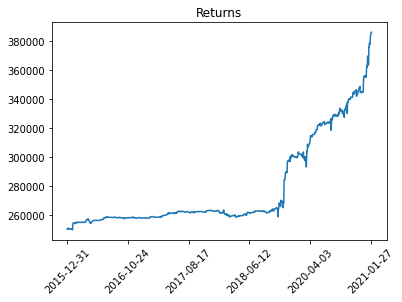

Returns: [0.54527226]
Sharpe Ratio: 1.76


In [42]:
trading_limits = [5, 1, 3]
allocation = [0.3, 0.4, 0.3]
# In-Sample
dates1, portfolio_values1, trade_records1 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2019-02-21")
dates2, portfolio_values2, trade_records2 = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2020-02-23", end_date = "2021-01-31", cash = portfolio_values1[-1])
plt.title("Returns")
dates = dates1 + dates2
portfolio_values = portfolio_values1 + portfolio_values2
plot_returns(dates, portfolio_values)
#print("".join(trade_records[:11]))
print("Returns: {}".format([portfolio_values[-1] - portfolio_values[0]]/portfolio_values[0]))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

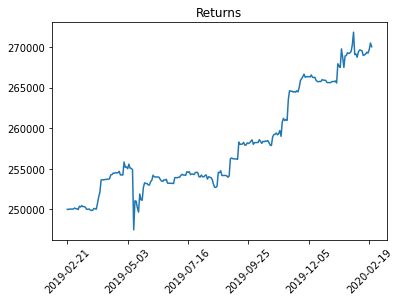

Returns: [0.08010189]
Sharpe Ratio: 1.67


In [43]:
# Out-Sample
dates, portfolio_values, trade_records = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2019-02-22", end_date = "2020-02-21")
plt.title("Returns")
plot_returns(dates, portfolio_values)
#print("".join(trade_records[:11]))
print("Returns: {}".format([portfolio_values[-1] - portfolio_values[0]]/portfolio_values[0]))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

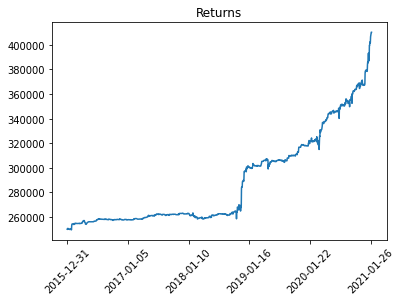

Opening positions:
We sold 385 shares of ADR (WBK) at the price of 23.43654 on 2016-01-04
We bought 385 shares of underlying stock (WBC) at the price of 32.70267 foreign dollars on 2016-01-04
Opening positions:
We sold 15 shares of ADR (JHX) at the price of 12.43755 on 2016-01-04
We bought 15 shares of underlying stock (JHX) at the price of 17.077059999999996 foreign dollars on 2016-01-04
Opening positions:
We sold 32 shares of ADR (TAK) at the price of 24.49548 on 2016-01-04
We bought 16 shares of underlying stock (4502) at the price of 5876.870999999999 foreign dollars on 2016-01-04
Opening positions:
We sold 213 shares of ADR (SNP) at the price of 58.33161 on 2016-01-04

Returns: [0.64124213]
Sharpe Ratio: 1.75


In [44]:
# 2016-01-01 to 2021-01-31
dates, portfolio_values, trade_records = final_strategy(df_dict, datelist, trading_limits, allocation, hp, list_pairs, start_date = "2016-01-01", end_date = "2021-01-31")
plt.title("Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))
print("Returns: {}".format([portfolio_values[-1] - portfolio_values[0]]/portfolio_values[0]))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))